# Modélisation de la consommation et de la production d'un foyer équipé d'un photovoltaique, d'une éolienne et d'une batterie

Ce notebook permet de reproduire les expériences du papier :
    
    
## Estimation de la consommation
On estime que le foyer a une consommation électrique annuelle de 20000 kWh[1]. Les données proviennent du gouvernement français[2]. Les heures creuses/pleines sont prises pour Cachan.

[1] http://www.monenergie.net/consommation-moyenne-d-electricite-d-une-maison.php "Consommation moyenne d'une maison"

[2] https://www.data.gouv.fr/fr/datasets/bilan-electrique-au-pas-demi-heure/ "Dataset de consommation"

In [1]:
# -*- coding: latin-1 -*-
import locale, time
locale.setlocale(locale.LC_TIME, "fr_FR".encode('ascii'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from __future__ import unicode_literals
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
rc('font',**{'family':'serif','serif':['Times']})

%matplotlib inline
dataframe=pd.read_csv('dataset/bilan-electrique-demi-heure.csv', sep=";")
dataframe["Horodate"]=pd.to_datetime(dataframe["Horodate"])
dataframe = dataframe.set_index(['Horodate'])
df = dataframe[dataframe.index.year == 2013].copy()
df = df.sort_index()
df = df.resample('60T').sum()
hour = df.index.hour
month = df.index.month
HC = ((hour >= 2) & (hour < 7)) | ((hour >= 14) & (hour < 17))
HP =  ((hour >= 7) & (hour < 14)) | (hour >= 17) | (hour < 2)
consoPerso = 20000 # consommation annuelle kWh d'un foyer
# 20000 pour un foyer : http://www.monenergie.net/consommation-moyenne-d-electricite-d-une-maison.php
consoTotale   = df["Consommation residentielle profilee (W)"].sum()/1000 # consommation annuelle en kWh
df["Consommation (kW)"] = df["Consommation residentielle profilee (W)"]/1000
df["Consommation (kW)"] = df["Consommation (kW)"]*consoPerso/consoTotale

/Library/Python/2.7/site-packages/pandas/indexes/base.py:1396: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine
/Library/Python/2.7/site-packages/pandas/indexes/base.py:2134: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(key)
/Library/Python/2.7/site-packages/pandas/indexes/base.py:2136: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(self._maybe_cast_indexer(key))


## Prix de l'électricité
http://www.kelwatt.fr/guide/prix-par-mois#base

http://www.jechange.fr/energie/electricite/guides/prix-electricite-kwh-2435
- Abonnement annuel : 117,50 €
- Evolution des prix sur 2013 en suivant l'historique de :
http://www.kelwatt.fr/prix/tarif-bleu-edf#trouver-moins-cher-tarif-bleu
- prix du kWh: (heures pleines, heures creuses) = 0.129, 0.105


Rachat du photovoltaïque :
- Intégration au bâti :
    0-9 kWc = 24,29 cts€/kWh (24,64 cts€/kWh le trimestre précédent)
- Intégration simplifiée au bâti :
    0-36 kW = 12,72 cts€/kWh (13,27 cts€/kWh le trimestre précédent)
    36-100 kW = 12,13 cts€/kWh (12,62 cts€/kWh le trimestre précédent)
- Sans intégration, ou hors critères ci-dessus, ou au sol:
    5,65 c€/kWh (5,96 cts€/kwh le trimestre précédent)

Rachat de l'éolien :
- http://www.developpement-durable.gouv.fr/Les-tarifs-d-achat-de-l,12195.html
- prix: 8.2cEUR/kWh


/Library/Python/2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


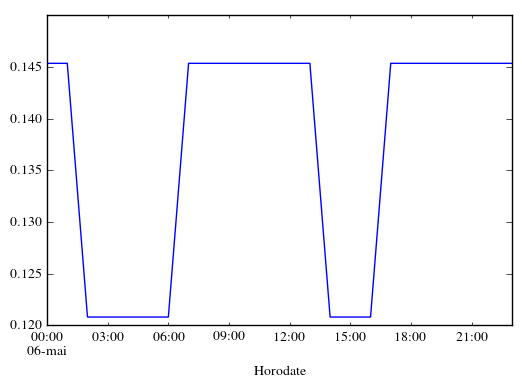

In [2]:
prix_achat = np.array([0.129, 0.105])
evolution = np.array([2.3, 0, 0, 0 ,0 ,0, 0, 5, 0,0,0,0])
inflation = (1+evolution/100).cumprod()
df["Inflation"] = pd.Series(np.nan, df.index)
df["Inflation"].loc[(df.index.day == 1) & (df.index.hour == 0)] = inflation
df["Inflation"] = df["Inflation"].fillna(method='ffill')
abonnement = 117.5
abonnement_heure = abonnement/365.25/24
prix_hc = prix_achat[1]* df["Inflation"] +abonnement_heure
prix_hp = prix_achat[0]* df["Inflation"] +abonnement_heure
prix = prix_hp
prix.loc[(hour >= 2) & (hour < 7)] = prix_hc[(hour >= 2) & (hour < 7)]
prix.loc[(hour >= 14) & (hour < 17)] = prix_hc[(hour >= 14) & (hour < 17)]
mai6 = (df.index.day == 6) & (df.index.month == 5)
prix[mai6].plot()
df["Prix consommation (EUR/kWh)"] = df["Consommation (kW)"].copy()
df["Prix consommation (EUR/kWh)"].loc[HC] *= prix_hc
df["Prix consommation (EUR/kWh)"].loc[HP] *= prix_hp
df["Depense"] = df["Prix consommation (EUR/kWh)"].cumsum()


prix_pv = 0.1272
prix_eolien = 0.082

In [3]:
def Depense(manque, rachat=prix_eolien):
    depense = pd.Series(0, index=manque.index)
    depense[manque.values < 0] += manque[manque.values < 0]*rachat
    depense[(manque.values > 0)] += manque[(manque.values > 0)]*prix
    return depense.cumsum()

# test:
# manque = pd.Series(np.random.rand(len(bale.index)), index=bale.index)
# Depense(manque,(bale.index.year == 2013)).plot()

# Lecture des donnés historiques de Bâle en ensoleillement et température :
https://www.meteoblue.com/fr/historyplus

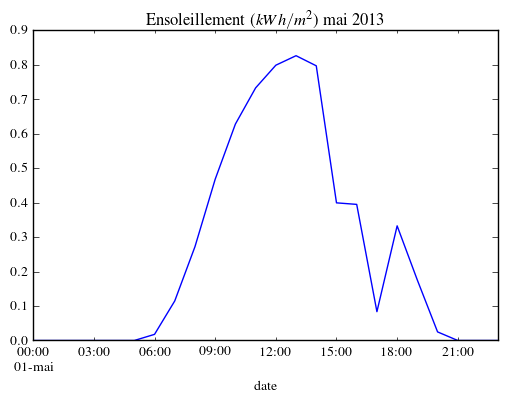

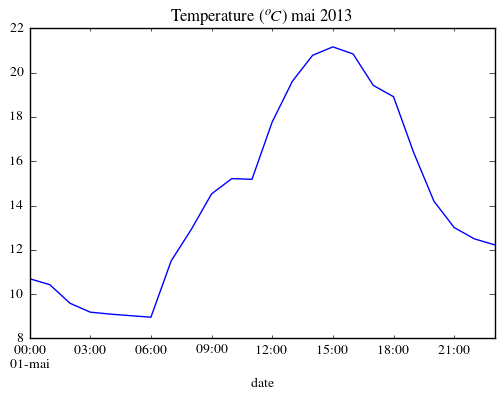

In [4]:
bale=pd.read_csv('dataset/bale.csv', sep=";", skiprows=11)
bale["date"]=pd.to_datetime({
        'year': bale["Year"],
        'month': bale["Month"],
        'day': bale["Day"],
        'hour': bale["Hour"],
                    })
bale = bale.set_index(['date'])
bale = bale[(bale.index.year == 2013)]
bale["temperature"] = bale["Temperature  [2 m above gnd]"]
bale["radiation"] = bale["Shortwave Radiation - backwards  [sfc]"]/1000
bale["consommation"] = df['Consommation (kW)']
bale["depense"] = df["Depense"] # depense sans PV
bale["inflation"] = df["Inflation"]
bale['rafale'] = bale['Wind Gust  [10 m above gnd]']
bale['vent'] = bale['Wind speed  [10 m above gnd]']

premierMai = (bale.index.month == 5) & (bale.index.day == 1)
bale[premierMai].plot(y="radiation",title="Ensoleillement ($kWh/m^2$) mai 2013")
plt.legend().remove()
bale[premierMai].plot(y="temperature",title="Temperature ($^oC$) mai 2013")
plt.legend().remove()

## Production d'électricité photovoltaïque et éolienne
Thèse O. Gergaud, modèle polynomial
$P_{G,max} = P_1\left[ 1 + P_2 (T - T_{ref}) \right] (P_3 + E_s)$
avec :
- $P_1 = 0.99$ (ou 0.099 pour un panneau)
- $P_2 = -4.7e^{-3} K^{-1}$ dérive en température
- $P_3 = 45$
- $T_{ref} = 24°C$
- $E_s$ ensoleillement dans le plan de panneaux (W/m^2)

Eolienne considérée :
- http://www.fw4sea.com/produits-fr/fiches-techniques/80-fiches-techniques-fr/88-f180-50

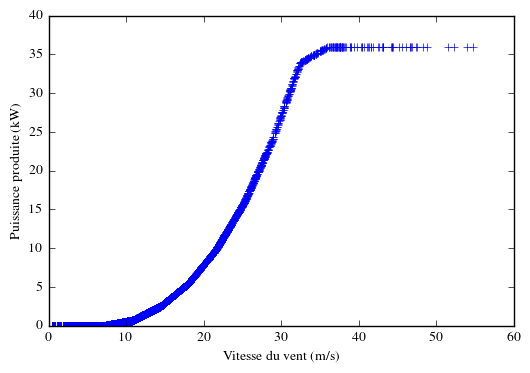

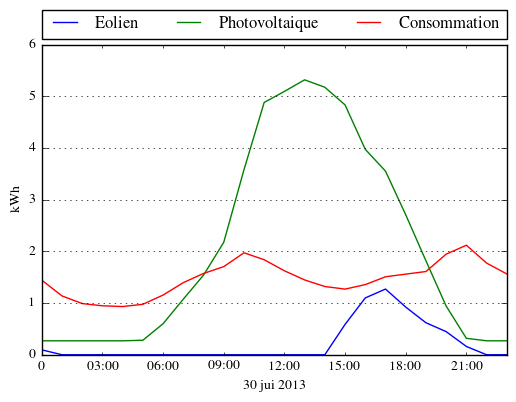

In [62]:
P1 =  6 #rendement de 30m2 de panneau solaire
P2 = -4.7e-3 #deviation en temperatrue
P3 = 45e-3 #gain supplémentaire
Tref = 24
NOCT = 43
bale["prod-pv"] = P1*( 1 + P2*(bale["radiation"]* (NOCT-20)/800))*(P3+bale["radiation"])
period = (bale.index.month == 6) & (bale.index.day == 30)

# F180-50
# puissance = np.ones(20)* 50.0
# puissance[:10]= [0,0,1,2.16,5.12,9.5,15.55, 23.52, 33.65, 45.0]
# Modele F100-10
puissance = np.ones(20)* 10.0

# Modele F180-36
puissance = np.ones(20)* 36.0
puissance[:10]= [0,0,0,0.68,2.5, 5.45, 9.85, 15.9, 23.85, 33.9]
bale['prod-eol'] = np.interp( bale['vent'].values, np.arange(20.0)*3.6, puissance)
ax = plt.plot(bale['vent'], bale['prod-eol'].values, '+')
plt.xlabel("Vitesse du vent (m/s)")
plt.ylabel("Puissance produite (kW)")
plt.show()



ax = bale[period].plot(y='prod-eol', label="Eolien")
bale[period].plot(y="prod-pv", label="Photovoltaique", ax=ax)
bale[period].plot(y="consommation", label="Consommation", ax=ax)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
ax.yaxis.grid()
plt.xlabel(bale[period].index[0].strftime("%d %b %Y"))
plt.ylabel("kWh")
ticklabels = ['']*len( bale[period].index)
ticklabels[::3] = [item.strftime('%-H') for item in  bale[period].index[::3]]
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
# ax.gcf().autofmt_xdate()



## Loi de commande 
    - Vente: on vend tout, puis on achète selon nos besoins
    - Consommation: on consomme ce qu'on produit, puis on vend les surplus
    - BatterieNormale: on stocke les surplus
    - BatterieAchat: à la fin d'une période d'heures creuses, on achète pour remplir la batterie jusqu'à un certain stade
    - BatterieAchatOpt: à la fin d'une période d'heures creuses, on achète pour remplir la batterie afin ne pas manquer d'électricité lors d'une période d'heures pleines

In [6]:
def Vente(consommation, production, mask, rachat=prix_eolien):
    depense = -production[mask]*rachat
    depense += consommation[mask]*prix[mask]
    return depense.cumsum()

def Consommation(consommation, production, mask, rachat=prix_eolien):
    besoin = (consommation - production)
    return Depense(besoin[mask], rachat)

def BatterieNormale(besoin, cap_batterie, period, rendement=0.9):
    batteriePleine = pd.Series(cap_batterie, index=bale[period].index) 
    stockage = pd.Series(0, index=bale[period].index) 
    manque = pd.Series(0, index=bale[period].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    stockagePre = 0.0
    for p in bale[period].index:
        m=  bale[period].index == p
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and -besoin[m].values[0] > (cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = (cap_batterie - stockagePre) -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and -besoin[m].values[0] < (cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        stockagePre = stockage[m].values[0]

    return [manque, stockage]

def BatterieAchat(besoin, cap_batterie, period, coeff = 1.0, rendement = 0.9):
    batteriePleine = pd.Series(cap_batterie, index=bale[period].index) 
    stockage = pd.Series(0, index=bale[period].index) 
    manque = pd.Series(0, index=bale[period].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    stockagePre = 0.0
    for p in bale[period].index:
        m=  bale[period].index == p
        transfert = 0 # > 0 si maison -> batterie, <= 0 sinon
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] > cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = cap_batterie - stockagePre -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] < cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        h = p.hour
        if (h == 16 or h == 6) and (stockage[m].values[0] < cap_batterie*coeff):
            manque[m] += cap_batterie*coeff - stockage[m].values[0] 
            stockage[m] = cap_batterie*coeff 
        stockagePre = stockage[m].values[0]

    return [manque, stockage]

def Anticipation(besoin,cap_batterie, period, rendement = 0.9):
# calcul ce dont il faut acheter pour subvenir aux besoins futurs de la HP
    [manque, stockage] = BatterieNormale(besoin, cap_batterie, period, rendement)
    return manque[manque > 0 ].sum()
    
def BatterieAchatOptimal(besoin, cap_batterie, period, rendement = 0.9):
    batteriePleine = pd.Series(cap_batterie, index=bale[period].index) 
    stockage = pd.Series(0, index=bale[period].index) 
    manque = pd.Series(0, index=bale[period].index)   # manque  : > 0 si reseau > maison, <= 0 sinon
    stockagePre = 0.0
    for p in bale[period].index:
        m=  bale[period].index == p
        transfert = 0 # > 0 si maison -> batterie, <= 0 sinon
        if besoin[m].values[0] > 0:
            manque[m] = max(-stockagePre*rendement+besoin[m].values[0],0)
            stockage[m] = max(stockagePre-besoin[m].values[0]/rendement,0)
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] > cap_batterie - stockagePre):
                stockage[m]=cap_batterie
                manque[m] = cap_batterie - stockagePre -(-besoin[m].values[0]) # < 0 
        elif besoin[m].values[0] < 0 and (-besoin[m].values[0] < cap_batterie - stockagePre):
                manque[m] = 0
                stockage[m] = -besoin[m].values[0] + stockagePre
        h = p.hour
        if (h == 16):
            periodHP = period & (bale.index >= (p + pd.DateOffset(hours=1)))
            periodHP &= bale.index <= (p + pd.DateOffset(hours=10))
            besoinHP = Anticipation(besoin[periodHP],cap_batterie, periodHP)
            if (besoinHP > stockage[m].values[0] ):
                manque[m] += min(besoinHP, cap_batterie) - stockage[m].values[0] 
                stockage[m] += min(besoinHP, cap_batterie)
        if (h == 6):
            periodHP = period & (bale.index >= (p + pd.DateOffset(hours=1)))
            periodHP &= bale.index <= (p + pd.DateOffset(hours=8))
            besoinHP = Anticipation(besoin[periodHP],cap_batterie, periodHP)
            if (besoinHP > stockage[m].values[0] ):
                manque[m] += min(besoinHP, cap_batterie) - stockage[m].values[0] 
                stockage[m] = min(besoinHP, cap_batterie)

        stockagePre = stockage[m].values[0]

    return [manque, stockage]

## Besoin, manque et stockage sur une journée

1.72972966991


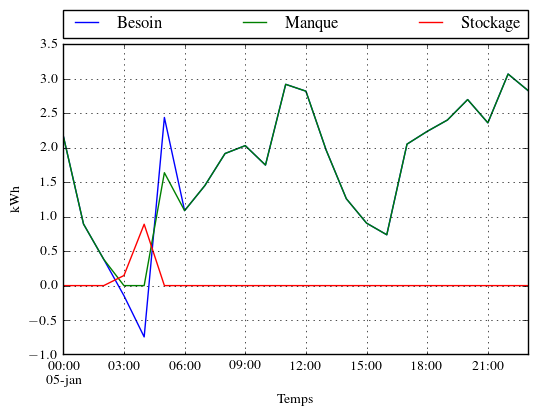

In [63]:
period = (bale.index.month <= 1)
cap_batterie = 7
besoin = (bale['consommation'] - bale['prod-eol'])[period]
speriod = (besoin.index.month == 1) & (besoin.index.day == 5)
[manque, stockage] = BatterieNormale(besoin,  cap_batterie, period)
besoin[speriod].plot(label="Besoin")
manque[speriod].plot(label="Manque")
stockage[speriod].plot(label="Stockage")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
ax.grid(True, which='both')
plt.xlabel("Temps")
plt.ylabel("kWh")
print besoin[speriod].mean()

## Facture avec le photovoltaïque

In [26]:
# period = (bale.index.month == 1) & (bale.index.day == 1)
period = (bale.index.year == 2013)
cap_batterie = 14
besoin = (bale['consommation'] - bale['prod-pv'])[period]
pv = {}
# 1. en vendant systematiquement notre production de photovoltaique
pv['Vente'] = Vente(bale['consommation'], bale['prod-pv'], period, prix_pv)

# 2. On consomme notre production de photovoltaique et on vend ce qu'on ne consomme pas
pv["Consommation"] = Consommation(bale['consommation'], bale['prod-pv'], period, prix_pv)

# 3. On stocke et on n'utilise notre production qu'aux HP
[manqueNormal, stockageN] = BatterieNormale(besoin,  cap_batterie, period)
pv["Normal"] = Depense(manqueNormal,prix_pv)

# 4. On remplit la batterie en fin de HC
[manqueAchat, stockageAchat] = BatterieAchat(besoin, cap_batterie, period, 1.0)
pv["Achat"] = Depense(manqueAchat, prix_pv)

# 5. On remplit la batterie en fin de HC en prévoyant notre besoin futur
[manqueOpt, stockageOpt] = BatterieAchatOptimal(besoin, cap_batterie, period)
pv["Optimal"] = Depense(manqueOpt, prix_pv)


1210.97589946
1333.5606035
1276.76195263
1337.18407253
1434.94513709


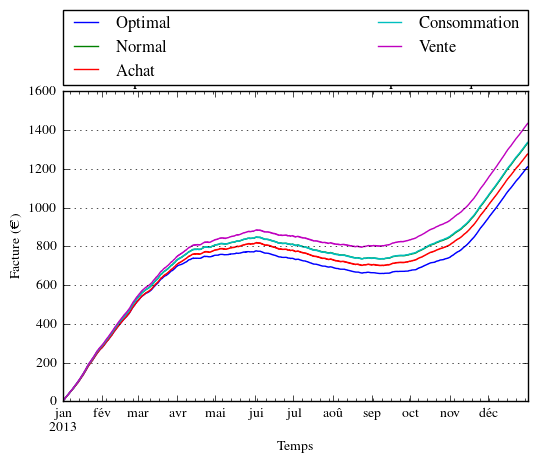

In [74]:
for name in pv:
    pv[name].plot(label=name)
    print pv[name][-1]
plt.title("Comparaison des lois de consommation en photovoltaïque")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Temps")
plt.ylabel("Facture (€)")
ax.yaxis.grid()

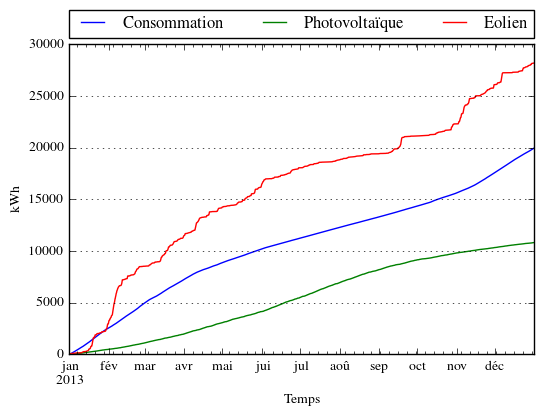

In [64]:
period = bale.index.year == 2013
cap_batterie = 14
bale['consommation'][period].cumsum().plot(label="Consommation")
bale['prod-pv'][period].cumsum().plot(label="Photovoltaïque")
bale['prod-eol'][period].cumsum().plot(label="Eolien")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel("Temps")
plt.ylabel("kWh")
ax = plt.gca()
ax.yaxis.grid()

## Facture avec l'éolien

In [65]:
# period = (bale.index.month == 1)# & (bale.index.day == 1)
period = (bale.index.year == 2013)
cap_batterie = 14
besoin = (bale['consommation'] - bale['prod-eol'])[period]
eol = {}

# 1. en vendant systematiquement notre production de photovoltaique
eol["Vente"] = Vente(bale['consommation'], bale['prod-eol'], period, prix_eolien)

# 2. On consomme notre production de photovoltaique et on vend ce qu'on ne consomme pas
eol["Consommation"] = Consommation(bale['consommation'], bale['prod-eol'], period, prix_eolien)

# 3. On stocke et on n'utilise notre production qu'aux HP
[manqueNormal, stockageN] = BatterieNormale(besoin,  cap_batterie, period)
eol["Normal"] = Depense(manqueNormal,prix_eolien)

# 4. On remplit la batterie en fin de HC
[manqueAchat, stockageAchat] = BatterieAchat(besoin, cap_batterie, period, 1.0)
eol["Achat"] = Depense(manqueAchat, prix_eolien)

# 5. On remplit la batterie en fin de HC en prévoyant notre besoin futur
[manqueOpt, stockageOpt] = BatterieAchatOptimal(besoin, cap_batterie, period)
eol["Optimal"] = Depense(manqueOpt, prix_eolien)

-200.518237515
-92.0278100553
-97.0628706318
15.9871453694
499.31305117


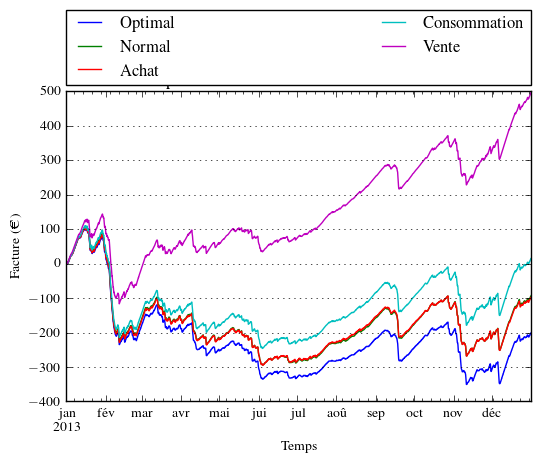

In [75]:
for name in eol:
    eol[name].plot(label=name)
    print eol[name][-1]
    
plt.title("Comparaison des lois de consommation en éolien")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Temps")
plt.ylabel("Facture (€)")
ax.yaxis.grid()

## Quelle batterie faut-il ?

In [37]:
batteries = range(2,20,2)#[7,10,14]
period = (bale.index.year == 2013)
cap_batterie = 14


# en photovoltaique
pv_batt = {}
besoin = (bale['consommation'] - bale['prod-pv'])[period]
for b in batteries:
    [manqueOpt, stockageOpt] = BatterieAchatOptimal(besoin, b, period)
    pv_batt[b] = Depense(manqueOpt, prix_pv)[-1]


# en eolien
eol_batt = {}
besoin = (bale['consommation'] - bale['prod-eol'])[period]
for b in batteries:
    [manqueOpt, stockageOpt] = BatterieAchatOptimal(besoin, b, period)
    eol_batt[b] = Depense(manqueOpt, prix_eolien)[-1]


# sans production
noprod_batt = {}
besoin = bale['consommation'][period]
for b in batteries:
    [manqueOpt, stockageOpt] = BatterieAchatOptimal(besoin, b, period)
    noprod_batt[b] = Depense(manqueOpt, 0)[-1]

2044.71401702


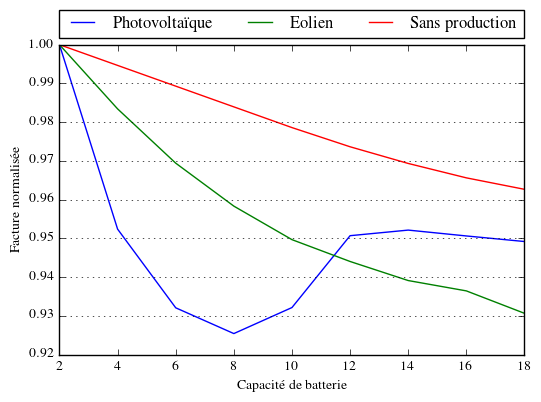

In [91]:
plt.plot(batteries, pv_batt.values()/max(pv_batt.values()), label="Photovoltaïque")
max_eol = np.max(np.abs(np.array(eol_batt.values())))
eol = (2*max_eol+ np.array(eol_batt.values()))
eol = eol/max(eol)
plt.plot(batteries,eol, label="Eolien")
plt.plot(batteries, noprod_batt.values()/max(noprod_batt.values()), label="Sans production")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
ax = plt.gca()
plt.xlabel("Capacité de batterie")
plt.ylabel("Facture normalisée")
ax.yaxis.grid()